In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sym 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
c=const.c.to("km/s")
from colossus.cosmology import cosmology
%matplotlib inline
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology on the basis of simulation

In [2]:
path_2_data = 'Most_massive_MD04.fits'
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
print(my_file[1].data.columns)
data = my_file[1].data

opening Most_massive_MD04.fits
ColDefs(
    name = 'RA_1'; format = 'E'
    name = 'DEC_1'; format = 'E'
    name = 'g_lat_1'; format = 'E'
    name = 'g_lon_1'; format = 'E'
    name = 'ecl_lat_1'; format = 'E'
    name = 'ecl_lon_1'; format = 'E'
    name = 'redshift_R_1'; format = 'E'
    name = 'redshift_S_1'; format = 'E'
    name = 'dL_1'; format = 'E'
    name = 'nH_1'; format = 'E'
    name = 'ebv_1'; format = 'E'
    name = 'galaxy_SMHMR_mass_1'; format = 'E'
    name = 'galaxy_star_formation_rate_1'; format = 'E'
    name = 'galaxy_is_quiescent_1'; format = 'E'
    name = 'galaxy_LX_hard_1'; format = 'E'
    name = 'galaxy_mag_abs_r_1'; format = 'E'
    name = 'galaxy_mag_r_1'; format = 'E'
    name = 'galaxy_UM_A_UV_1'; format = 'E'
    name = 'galaxy_UM_True_SM_1'; format = 'E'
    name = 'galaxy_UM_ICL_mass_1'; format = 'E'
    name = 'galaxy_UM_True_SFR_1'; format = 'E'
    name = 'galaxy_UM_Obs_UV_1'; format = 'E'
    name = 'HALO_id_1'; format = 'K'
    name = 'HALO_pid

In [3]:
# coordinates of the cluster 
# Redshift at the center of the cluster
z_cl = data.field('redshift_R_1')[0] #
ra_cl = data.field('RA_1')[0]*np.pi/180 # radians
dec_cl= data.field('DEC_1')[0]*np.pi/180 # radians    
r_cl = data.field('HALO_Rvir_1')[0]
# coordinates of the sub haloes
z   = data.field('redshift_R_2') # 
ra  = data.field('RA_2') * (np.pi/180) # degrees
dec = data.field('DEC_2') * (np.pi/180) # degrees

# 3D separation in Mpc, to be verified
r = data.field('separation') # Mpc

In [4]:
z_cl

0.33398816

In [5]:
z[1]

0.33419564

In [6]:
z.min(),z.max()

(0.3335465, 0.33446422)

In [7]:
data.field('RA_1')[0]


319.57388

In [8]:
data.field('DEC_1')[0]

-4.6388335

In [9]:
data.field('HALO_vmax_2')[0]

1454.9

In [10]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra * 180/np.pi, dec * 180/np.pi, unit='deg', frame='icrs') 
coordinate_cluster    = SkyCoord( ra_cl * 180/np.pi, dec_cl*180/np.pi, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)

In [11]:
# Comoving distance
D = cosmos.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)

the cluster at redshift  0.33398816  is at dC= 1359.1182184541588 Mpc


In [12]:
# Angular diameter distance
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl), 'per radian')
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl)/(180/np.pi), 'per degree')
print('Angular diameter distance at the clusters redshift :' , (cosmos.angular_diameter_distance(z_cl)/(180/np.pi)).to(u.kpc)/60, 'per arc minute    ')

Angular diameter distance at the clusters redshift : 1018.8382920589 Mpc per radian
Angular diameter distance at the clusters redshift : 17.7820827418234 Mpc per degree
Angular diameter distance at the clusters redshift : 296.3680456970567 kpc per arc minute    


In [13]:
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj =  Angular_separation_Astropy_radian * cosmos.angular_diameter_distance(z_cl)/u.radian  # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max(), 'compared to the 3D virial radius', r_cl/1000)

min, max projected distance :  0.0 Mpc 1.4157164096832275 Mpc compared to the 3D virial radius 1.9035889892578124


In [14]:
r_proj.max()

<Quantity 1.4157164 Mpc>

In [15]:
# interpolated conversion between redshift and comoving distance
d_C = cosmos.comoving_distance(z)
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)

In [16]:
#rr    = dc_interpolation( ZZZZ )

In [17]:
D_cl=cosmos.comoving_distance(z)
d_C = D_cl
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian*180/np.pi   - 180 ) * np.pi / 180.
    theta = (dec_radian*180/np.pi + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

# get 3D Cartesian positions of the sub haloes
xx, yy, zz = get_x_y_z(ra, dec, dc_interpolation(z))

print('x mean, std',np.mean(data.field('HALO_x_2')-xx), np.std(data.field('HALO_x_2')-xx))
print('x mean, std',np.mean(data.field('HALO_y_2')-yy), np.std(data.field('HALO_y_2')-yy))
print('x mean, std',np.mean(data.field('HALO_z_2')-zz), np.std(data.field('HALO_z_2')-zz))

# get 3D Cartesian positions of the cluster
xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, dc_interpolation(z_cl))
print('ra,dec,z=',ra_cl, dec_cl, z_cl, '\n x,y,z=',xx_cl, yy_cl, zz_cl)

# array of distances between sub haloes and the cluster : 
distances = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2)

x mean, std -2.2749552953386206e-05 0.0004152230923755402
x mean, std -0.00023499888141364963 0.00042522407380780745
x mean, std 4.557050177504702e-05 0.00010263843485104863
ra,dec,z= 5.577616462721699 -0.08096291842468864 0.33398816 
 x,y,z= -1031.229798280288 878.4561999014163 109.91799506367586


In [18]:
distances.min()

0.00017367071932791525

In [19]:
np.sort(r_proj)

<Quantity [0.        , 0.04021558, 0.05417997, 0.07299431, 0.10984141,
           0.12333452, 0.1253532 , 0.13193955, 0.13213845, 0.13352363,
           0.15559523, 0.15801936, 0.1678664 , 0.1680192 , 0.17890458,
           0.19280197, 0.19541936, 0.20717607, 0.20754026, 0.21066771,
           0.21391444, 0.215508  , 0.22163433, 0.22461325, 0.23124085,
           0.24072467, 0.24145712, 0.24335721, 0.24433285, 0.24749677,
           0.2540283 , 0.25600204, 0.2598308 , 0.26169884, 0.26348042,
           0.26640543, 0.2756686 , 0.2759897 , 0.27639022, 0.28045925,
           0.28621185, 0.28633457, 0.2878536 , 0.29109773, 0.29292306,
           0.29768258, 0.29828244, 0.30107   , 0.30237114, 0.30356288,
           0.30537707, 0.3137931 , 0.3227886 , 0.3248158 , 0.32858166,
           0.3285886 , 0.3378612 , 0.33955607, 0.34241024, 0.3429453 ,
           0.3454577 , 0.34852648, 0.34898108, 0.35398793, 0.35855034,
           0.36036316, 0.36098054, 0.37255323, 0.3735032 , 0.37564716,
      

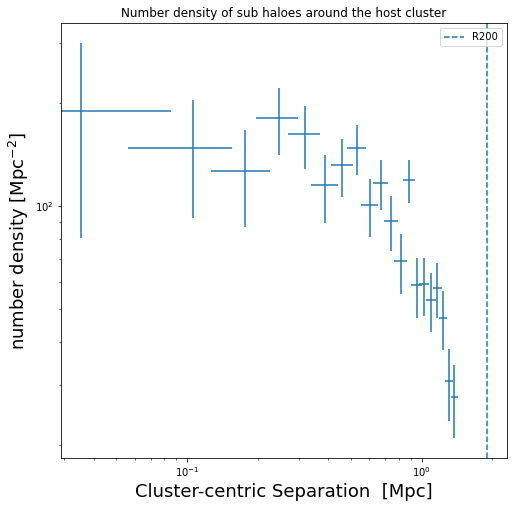

In [20]:
# create histogram of distances in Mpc
#%matplotlib notebook

# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), 20)
# Three D distance
N_3D, bins_3D = np.histogram(np.array(distances), 20)

#Getting the number density profile in 2D 
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )

# central point of each separation 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
plt.figure(0, (8, 8))

#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=0.1/2, ls='')
plt.yscale('log')
plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=1.90,linestyle='dashed',label = 'R200')
plt.legend(loc=1, numpoints=1)

plt.show()


/home/atul/anaconda3/lib/python3.9/site-packages/colossus/halo/profile_nfw.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return rhos / x / (1.0 + x)**2
/tmp/ipykernel_15257/2680358035.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=0.1/2, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'simulation')


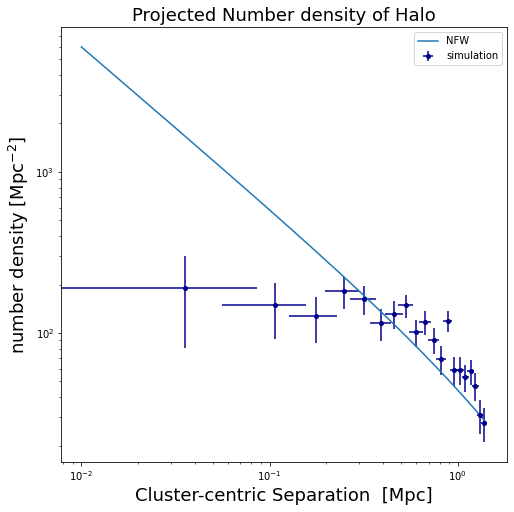

In [21]:

R = np.arange(0., 1.41, 0.01)
# plotting the de-projected number density wrt actual distance from the cluster center
from colossus.halo import profile_nfw

Rs=6 #Rs = Rvir / c

rhos = 10.0

p_nfw = profile_nfw.NFWProfile(rhos , Rs)
rho_nfw = p_nfw.density(R)

plt.figure(0, (8, 8))

plt.title('Projected Number density of Halo',fontsize=18)
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 

plt.plot(R, 1*rho_nfw , label = 'NFW');
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=0.1/2, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'simulation')


#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', markersize=12)
#plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/2, ls='', label = 'simulation')


plt.yscale('log')
plt.xscale('log')

plt.legend(loc=1, numpoints=1)

plt.show()



In [22]:
#Ns,rs=np.histogram(r)
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

r_act = (bins_3D[1:] + bins_3D[:-1])/2.

/tmp/ipykernel_15257/3862076952.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(r_act, number_density, xerr=0.1/2., ls='', yerr=number_density * N_3D**-0.5, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label='direct estimate')


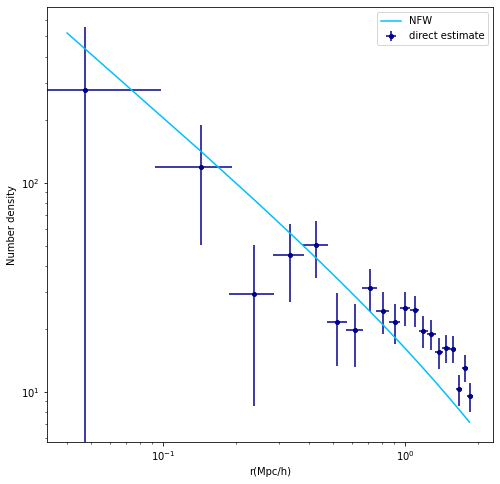

In [23]:
from colossus.halo import profile_nfw
#cosmology.setCosmology('planck18')

rhos = 3
rs = 7
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

# taking a dataset to model 
r = np.arange(0.04,1.9,0.1)
rho_data = prof.density(r)

# Generate random scatter around the true surface density profile

sigma_true = prof.density(r)


plt.figure(0, (8, 8))

plt.loglog()


plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'NFW')
plt.errorbar(r_act, number_density, xerr=0.1/2., ls='', yerr=number_density * N_3D**-0.5, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label='direct estimate')
plt.xlabel('r(Mpc/h)')
plt.ylabel('Number density')
#plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/2, ls='', label = 'simulation')

plt.legend();

In [24]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R)/((R**2 - r**2)**0.5))

    r_array = np.arange(0.05, 1.9, 0.01)
    nu_all=[integrate.quad(nu, r_i, 1.9, args=(r_i))[0] for r_i in r_array]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)

r_array = np.arange(0.05, 1.9, 0.01)

/tmp/ipykernel_15257/3470430887.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i, 1.9, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_15257/3470430887.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  nu_all=[integrate.quad(nu, r_i, 1.9, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_15257/3470430887.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  nu_all=[integrate.quad(nu, r_i, 

<IPython.core.display.Javascript object>


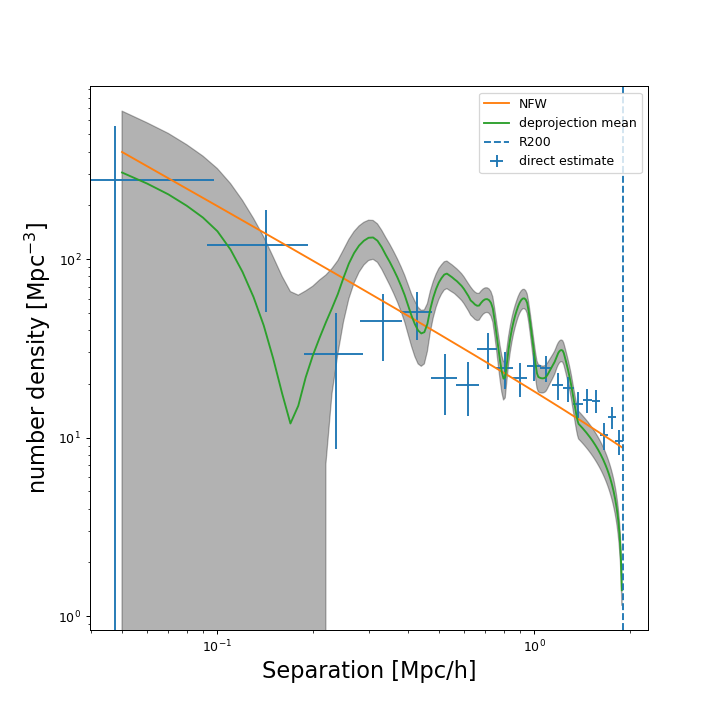

In [33]:
# plotting the de-projected number density wrt actual distance from the cluster center
from colossus.halo import profile_nfw

Rs=20 #Rs = Rvir / c
rhos = 1.0

p_nfw = profile_nfw.NFWProfile(rhos , Rs)

rho_nfw = p_nfw.density(r_array)

plt.title('3d/actual Number density')

plt.figure(0, (8, 8))

plt.errorbar(r_act, number_density, xerr=0.1/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
plt.plot(r_array, 1*rho_nfw , label = 'NFW');
plt.plot(r_array, nu_all,  label='deprojection mean',)
plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')

plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)
plt.axvline(x=1.90,linestyle='dashed',label = 'R200')
plt.legend(loc=1, numpoints=1)

plt.yscale('log')
plt.xscale('log')



In [26]:
from astLib import astCoords as aco
from astLib import astStats as ast
from astLib import astCalc as aca


# aardvark simulation cosmology
aca.H0 = 67.77
aca.OMEGA_M0 = 0.307115
aca.OMEGA_L0 = 0.692885
# Om0=0.307115, Ode0=0.692885
vd=880

In [27]:
np.sqrt(3)* vd /(10*aca.H0 * aca.Ez(z_cl))

1.885932695076058

In [28]:
c.value*0.336336-c.value*0.333988

703.9126913840009

<IPython.core.display.Javascript object>


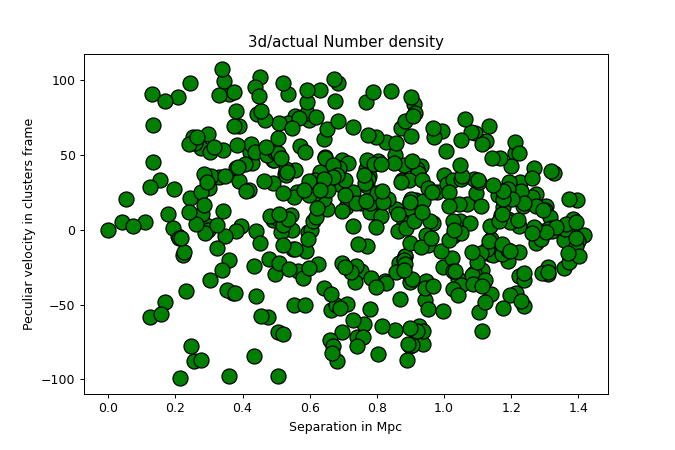

In [29]:
%matplotlib notebook
# Peculiar velocities of a members from there spectrosocpic
# redshift and mean redshift of a cluster

c=const.c.to("km/s")

los_v= c*(z - z_cl)/(1 + z_cl)
los_v
plt.plot(r_proj,los_v, color='black', linestyle='none', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation in Mpc')
plt.ylabel('Peculiar velocity in clusters frame')
plt.show()

In [30]:
#critical density
cosmos.critical_density(z_cl)

<Quantity 1.22667386e-29 g / cm3>

In [ ]:

x = r / rs
x

In [ ]:
## NFW prediction for surface density
f1 = lambda x: (2/(x**2-1)) * (1 - ( 2/np.sqrt(1-x**2) * np.arctanh(np.sqrt((1-x)/(1+x))) ))
f2 = lambda x: (2/(x**2-1)) * (1 - ( 2/np.sqrt(x**2-1) * np.arctan(np.sqrt((x-1)/(1+x))) ))

f1(0.05714286),f2(0.2 )

In [ ]:
def calc_delta_c(c200):
    """Calculate characteristic overdensity from concentration.
    Parameters
    ----------
    c200 : ndarray or float
        Cluster concentration parameter.
    Returns
    ----------
    ndarray or float
        Cluster characteristic overdensity, of same type as c200.
    """
    top = (200. / 3.) * c200**3.
    bottom = np.log(1. + c200) - (c200 / (1. + c200))
    return (top / bottom)

In [ ]:
# where c is the concentration
C=0.2
del_C = (200/3) * (C**3) / (np.log(1+C) - C/(1+C))
del_C

In [34]:
def rho(self, r):
        """
        Computes the 3D NFW density :math:`\\rho(r)` at projected proper radii `r`.
        
        Parameters
        ----------
        r : float array
            Proper radial distance relative to the center of the lens in proper :math:`Mpc`.
        
        Returns
        -------
        rho : float array
            The density :math:`\\rho` in proper :math:`M_{\\odot}/\\text{Mpc}^3`
        """

        # define critical density rho_crit in proper M_sun Mpc^-3,
        rho_crit = self._cosmo.critical_density(self.zl)
        rho_crit = rho_crit.to(units.Msun/units.Mpc**3).value

        # evaluate NFW profile
        pref = self._del_c * rho_crit
        x = r / self._rs
        rho = pref / (x * (1+x)**2)

        return rho